In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Task 1

## 1a

In [1422]:
# dataset top 5 
df = pd.read_csv('data/trainA3.csv')
df_test = pd.read_csv('data/testA3.csv')
combined_df = pd.concat([df,df_test])
combined_df.head()

,ArticleId,Text,Category
0,1976,lifestyle governs mobile choice faster better ...,tech
1,1797,french honour director parker british film dir...,entertainment
2,1866,fockers fuel festive film chart comedy meet fo...,entertainment
3,1153,housewives lift channel 4 ratings debut us tel...,entertainment
4,342,u2 desire number one u2 three prestigious gram...,entertainment


In [1369]:
# shape of dataset
df.shape, df_test.shape, combined_df.shape

((428, 3), (106, 3), (534, 3))

In [1773]:
# preprocessing
vectorizer_combine = CountVectorizer()
vectorizer_combine.fit(combined_df.Text)
vector_combine = vectorizer_combine.transform(combined_df.Text)

train_x = vector_combine.toarray()[:428]
train_y = df['Category'].factorize(sort = True)[0]

test_x = vector_combine.toarray()[428:]
test_y = df_test['Category'].factorize(sort = True)[0]

print(f'train vector shape: {train_x.shape}\n')
print(f'test article vector:\n{test_x}')

train vector shape: (428, 14927)

test article vector:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


For the preprocessing, we verctorise the article via CountVectorizer() method, then pick first 428 as training data, and rest of rows as testing data.

In [1433]:
# dataframe for vectorized training dataset
frequency_matrix = pd.DataFrame(train_x, columns = vectorizer_combine.get_feature_names_out())
frequency_matrix['Class'] = train_y
frequency_matrix

,00,000,000th,001st,0051,007,0100,0130,028,0400,...,zombies,zone,zonealarm,zones,zoom,zooms,zooropa,zorro,zutons,Class
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1b

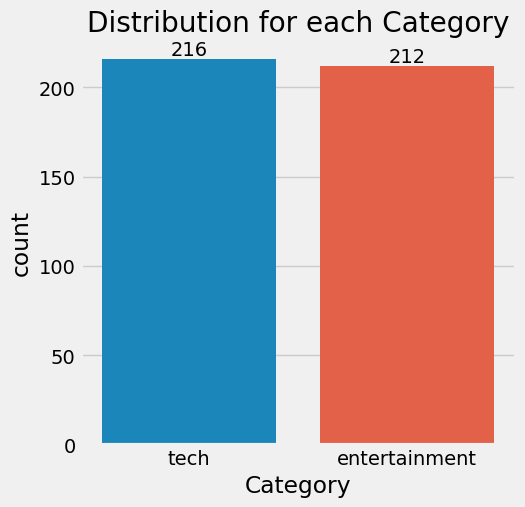

In [1775]:
# distribution of each Category
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(data = df, x = df.Category, ax = ax)
ax.bar_label(ax.containers[0])
ax.set_title('Distribution for each Category')
plt.style.use('fivethirtyeight')
plt.show()

The plot above shows us that the number of article which belongs to tech is slightly more than the number of artcle in entertainment.

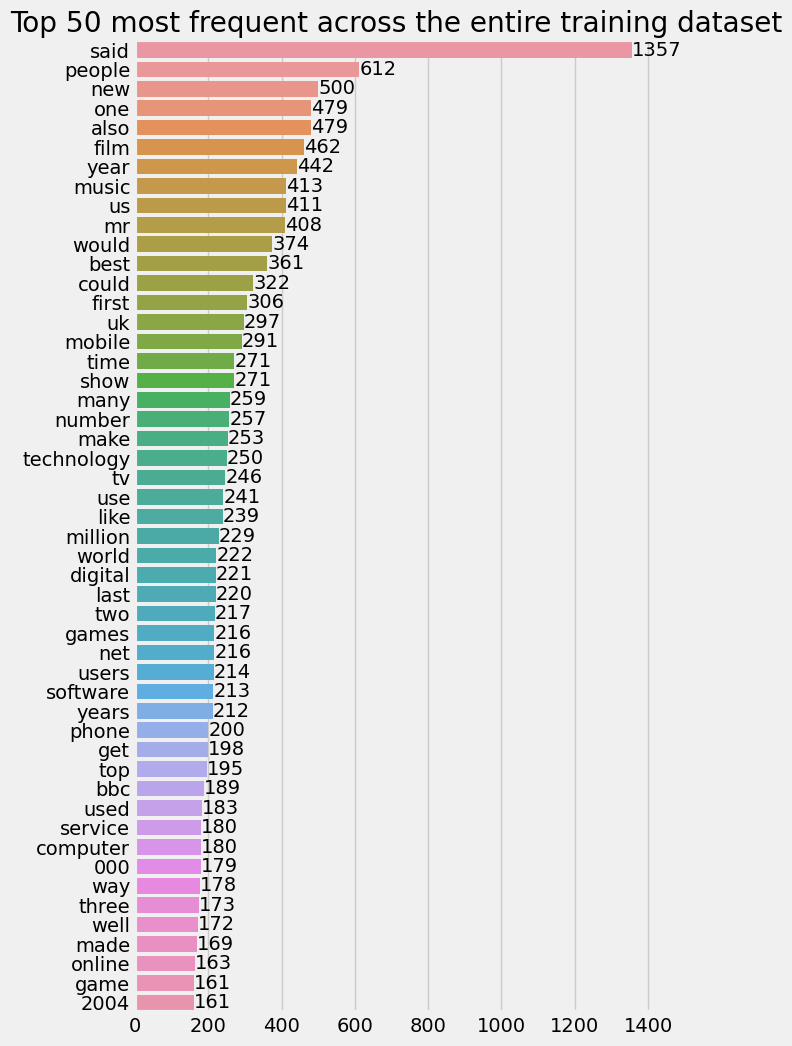

In [1779]:
counts = train_x.sum(axis=0)
indices = np.argsort(counts)[::-1][:50]

fig, ax = plt.subplots(figsize=(6,12))
sns.barplot(x = counts[indices], y = frequency_matrix.iloc[:,indices].columns)
ax.bar_label(ax.containers[0])
ax.set_title('Top 50 most frequent across the entire training dataset')
plt.show()

Except word 'said' and 'people', the frequency of remaining 48 words decline gradually, so we may expect some of above words to appear in the list of most identifiable words in task 2b naive bayes classifier.

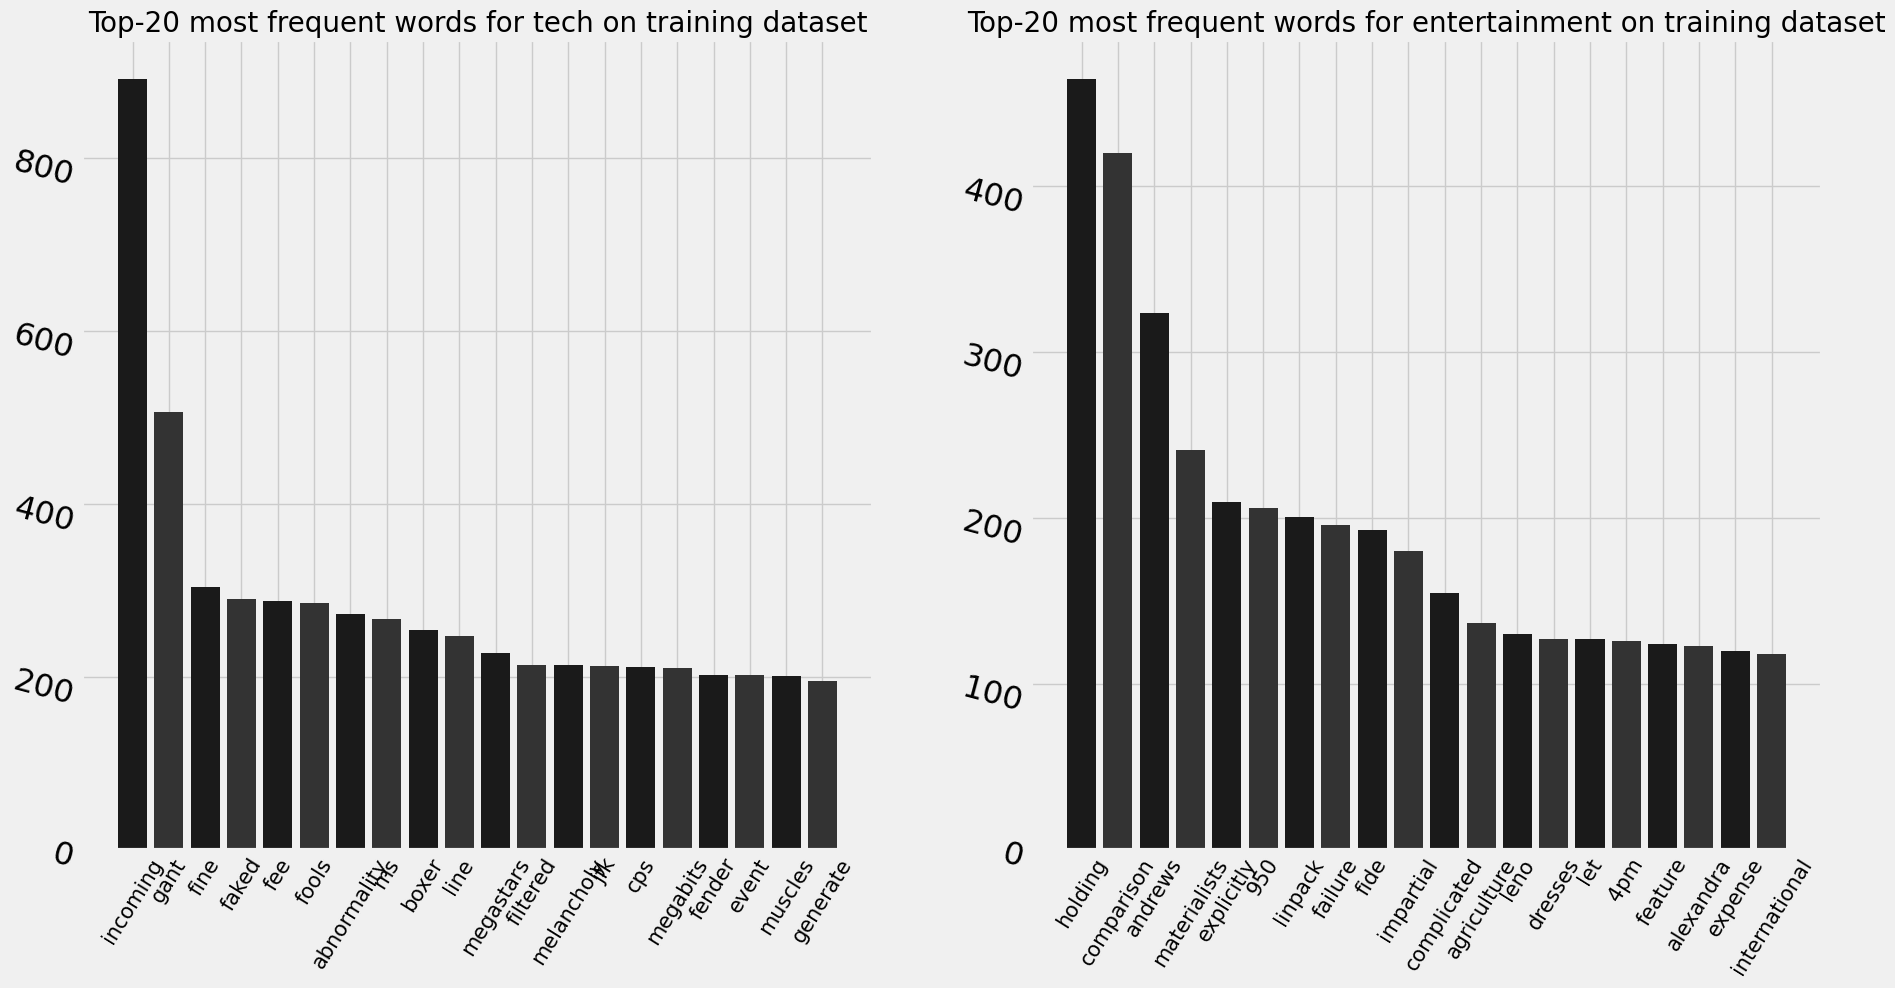

In [1780]:
def term_freq_plots():
    a,b,i = 1,2,1
    fig = plt.figure(figsize=(20,10))
    for n in range(2):
        plt.subplot(a, b, i)
        vectorizer1 = CountVectorizer()
        if n == 0:
            text = df[df['Category'] == 'tech'].Text
            label = 'tech'
        else:
            text = df[df['Category'] != 'tech'].Text
            label = 'entertainment'
        
        vectorizer1.fit(text)
        vector = vectorizer1.transform(text)
        counts = vector.toarray().sum(axis=0)
        indices = np.argsort(counts)[::-1][:20]
        plt.bar(frequency_matrix.iloc[:,indices].columns,counts[indices], color = ['.1', '.2'])
        plt.xticks(rotation=58, size = 15)
        plt.yticks(rotation=345, size = 23)
        plt.title(f'Top-20 most frequent words for {label} on training dataset', fontsize=20)

        i += 1
    plt.show()

term_freq_plots()
mpl.rcParams.update(mpl.rcParamsDefault)

It looks like that the number of Top-20 most frequent words for tech in training dataset is significantly higher than the number of Top-20 most frequent words for entertainment in training dataset.

# Task 2

## Logistic Regression

In [1395]:
from sklearn.linear_model import LogisticRegression

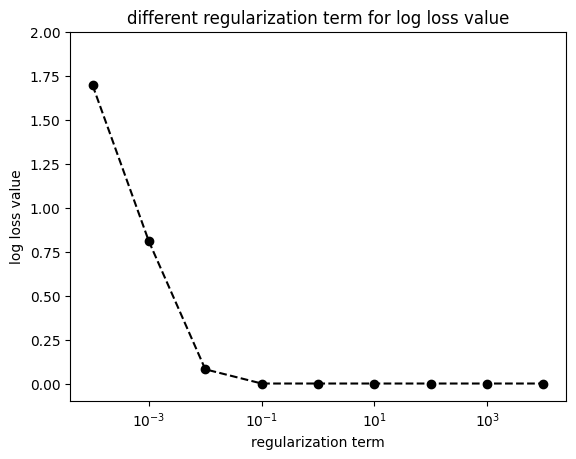

In [1400]:
C = [1/10000, 1/1000, 1/100, 1/10, 1, 10, 100, 1000, 10000]

def Logis_Reg(C):
    log_loss_lst = []
    for i,c in enumerate(C):
        LR = LogisticRegression(C = c)
        LR.fit(train_x, train_y)
        pred = LR.predict(train_x)
        log_loss = metrics.log_loss(train_y,pred)
        log_loss_lst.append(log_loss)
        
    plt.plot(C, log_loss_lst,linestyle='dashed',marker = 'o', color = 'k')
    plt.ylim(-.1, 2)
    plt.xscale('log')
    plt.ylabel('log loss value')
    plt.xlabel('regularization term')
    plt.title('different regularization term for log loss value')
    plt.show()
        
Logis_Reg(C)    

In [1781]:
LR = LogisticRegression(C = .1, penalty = 'l2')
LR

LogisticRegression(C=0.1)

As we can see that the log training loss is decreasing as the regularization term increase, however, the value of log training loss approaches 0 since the regularization term greater than 0.1, which means that the logistic regression model might start to overfit at point of 0.1, this is a reason why we choose C = 0.1.

## Naive Bayes

In [1782]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

def nb(nb_lst):
    x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, train_size = .7, random_state = 361)
    for i in nb_lst:
        i.fit(x_train,y_train)
        print(f'Accuracy Socre for {i.__class__.__name__}: {metrics.accuracy_score(y_test,i.predict(x_test))}')
        

nb_lst = [MultinomialNB(), GaussianNB(), BernoulliNB()]
nb(nb_lst)

Accuracy Socre for MultinomialNB: 1.0
Accuracy Socre for GaussianNB: 0.9612403100775194
Accuracy Socre for BernoulliNB: 0.9922480620155039


The result above indicates that MultinomialNB classifier is more likely to fit this data properly.

In [1784]:
NB = MultinomialNB(alpha = 1)
NB.fit(train_x,train_y)

def top_20_words():
    ente_lst = NB.feature_log_prob_[0,:]
    tech_lst = NB.feature_log_prob_[1,:]
    order0 = ente_lst.argsort()[::-1][:20]
    order1 = tech_lst.argsort()[::-1][:20]
    freq_words = (frequency_matrix.iloc[:,order0].columns)
    freq_words1 = (frequency_matrix.iloc[:,order1].columns)
    freq_words2 = (ente_lst / tech_lst).argsort()[::-1][:20]

    print(f'Top 20 identifiable words for Categery entertainment:\n{list(freq_words)}', 
          f'Top 20 identifiable words for Categery tech:\n{list(freq_words1)}', 
          f'Top 20 identifiable words for max P(x_i|y = 0) / P(x_i|y != 0):\n{list(frequency_matrix.iloc[:,freq_words2].columns)}'
          ,sep = '\n\n')
    return freq_words,freq_words1,list(frequency_matrix.iloc[:,freq_words2].columns)

freq_words,freq_words1,freq_words2 = top_20_words()

Top 20 identifiable words for Categery entertainment:
['said', 'film', 'best', 'year', 'music', 'also', 'us', 'new', 'one', 'show', 'first', 'awards', 'tv', 'uk', 'last', 'actor', 'number', 'band', 'mr', 'star']

Top 20 identifiable words for Categery tech:
['said', 'people', 'new', 'mobile', 'mr', 'one', 'also', 'would', 'could', 'technology', 'use', 'net', 'users', 'software', 'games', 'us', 'music', 'many', 'year', 'phone']

Top 20 identifiable words for max P(x_i|y = 0) / P(x_i|y != 0):
['users', 'software', 'mobile', 'microsoft', 'broadband', 'virus', 'firms', 'net', 'pc', 'technology', 'phones', 'spam', 'games', 'gadget', 'phone', 'consumer', 'mobiles', 'machines', 'windows', 'gadgets']


As we have already assumed at task 1b, some words exactly exist in here, for second part of this question, in order to maximise the P(x_i|y = 1) / P(x_i|y != 1), we can either maximise the numerator, or minimise the denominator, in other words, we are trying to find the word that belongs to a certain category with high probability and low probability for another category, since category = 0 is tech in the training dataset, therefore we may expect this list of word all categorise as tech.

In [1742]:
def predictor():
    temp_model = make_pipeline(TfidfVectorizer(), NB)
    temp_model.fit(df.Text, df.Category)

    for i,words in enumerate((freq_words,freq_words1,freq_words2)):
        if i == 0:
            print('The true label for following words are "entertainment":')
        elif i == 1:
            print('The true label for following words are "tech":')
        else:
            print('The true label for following words are supposed to be "tech":')

        for n in words:
            print(f'prediction for word"{n}"', f'\t{temp_model.predict([n])}', end = '\n')
            
        if i < 2:
            print()
            print()
            print()

predictor()            

The true label for following words are "entertainment":
prediction for word"said" 	['tech']
prediction for word"film" 	['entertainment']
prediction for word"best" 	['entertainment']
prediction for word"year" 	['entertainment']
prediction for word"music" 	['entertainment']
prediction for word"also" 	['entertainment']
prediction for word"us" 	['entertainment']
prediction for word"new" 	['tech']
prediction for word"one" 	['tech']
prediction for word"show" 	['entertainment']
prediction for word"first" 	['entertainment']
prediction for word"awards" 	['entertainment']
prediction for word"tv" 	['entertainment']
prediction for word"uk" 	['tech']
prediction for word"last" 	['entertainment']
prediction for word"actor" 	['entertainment']
prediction for word"number" 	['entertainment']
prediction for word"band" 	['entertainment']
prediction for word"mr" 	['tech']
prediction for word"star" 	['entertainment']



The true label for following words are "tech":
prediction for word"said" 	['tech']
predic

In [1785]:
NB = MultinomialNB(alpha = 1)

We set up a estimator via make_pipeline which allows us to predict every single word for each list of word. it's so obvious that the third one predict all correctly.

## Support Vector Machine 

In [1450]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

In [1452]:
# gain 2d training data
SVM_soft = SVC(kernel = 'linear')
SVM_kernel = SVC(kernel = 'rbf')
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(train_x)
Xreduced

array([[ 1.41646854e+01,  1.94087841e+00],
       [-4.54525888e+00,  1.15482569e+00],
       [-5.12925227e+00, -8.92918075e-01],
       [-3.96377515e+00, -2.09969927e+00],
       [ 8.12660225e-01,  9.85500271e-01],
       [ 4.35025699e-01, -1.83527874e+00],
       [-3.66594988e+00, -2.22384477e-01],
       [ 2.49327053e+00, -1.90370952e+00],
       [ 1.16031474e+01,  3.26244447e+00],
       [ 2.14064119e+00, -1.34063133e+00],
       [-1.56616719e+00, -1.99365208e+00],
       [-4.21079479e+00, -4.76445121e-01],
       [ 1.43125230e+00, -3.53620566e+00],
       [-1.09251138e+00, -1.67725485e+00],
       [ 1.43553945e+00, -5.54886363e-02],
       [-2.22253489e+00, -9.67915198e-01],
       [-1.59685426e+00, -8.98440643e-01],
       [ 3.05074950e+00,  1.41604579e+00],
       [ 1.98190136e+00, -3.17110858e+00],
       [-1.01892368e+00, -8.42513356e-01],
       [-8.56855758e-01, -1.34002875e+00],
       [-2.10053228e+00, -6.65514932e-01],
       [ 1.50923718e+00, -2.64465383e+00],
       [-4.

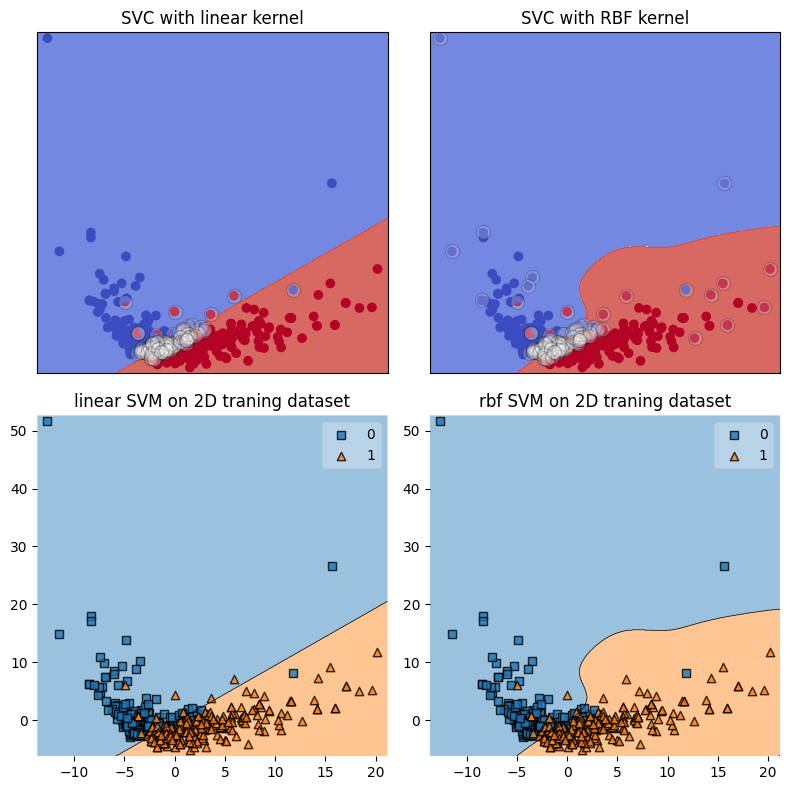

In [1453]:
def surface_plot(SVM_soft, SVM_kernel, Xreduced, train_y):
    
    SVM_soft.fit(Xreduced,train_y)
    SVM_kernel.fit(Xreduced,train_y)
    x_min, x_max = Xreduced[:, 0].min() - 1, Xreduced[:, 0].max() + 1
    y_min, y_max = Xreduced[:, 1].min() - 1, Xreduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                         np.arange(y_min, y_max, .02))
    
    titles = ['SVC with linear kernel', 'SVC with RBF kernel']

    fig = plt.figure(figsize=(8,8))
    for i, clf in enumerate((SVM_soft, SVM_kernel)):
        plt.subplot(2, 2, i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=train_y, cmap=plt.cm.coolwarm)
        plt.plot(clf.support_vectors_.T[0],clf.support_vectors_.T[1], markersize=10,
                 marker = 'o', mfc = 'white', linestyle = 'None', markeredgecolor='k', alpha = .2)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])
        
    plt.subplot(2, 2, 3)
    SVM_soft.fit(Xreduced,train_y)
    plot_decision_regions(Xreduced, train_y, clf=SVM_soft, legend=1)
    plt.title('linear SVM on 2D traning dataset')

    plt.subplot(2, 2, 4)
    SVM_kernel.fit(Xreduced,train_y)
    plot_decision_regions(Xreduced, train_y, clf=SVM_kernel, legend=1)
    plt.title('rbf SVM on 2D traning dataset')
    plt.tight_layout()

    plt.show()

surface_plot(SVM_soft, SVM_kernel, Xreduced, train_y)

The white cycles on top two plots are support vectors. Overall, the both soft-margin linear and rbf kernelised SVM separate categories properly. 

In [1787]:
# 3d for fun :)                         
#def svm_3d():
#    pcax = PCA(n_components=3)
#    Xreducedx = pcax.fit_transform(train_x)
#    s = SVM_soft.fit(Xreducedx, train_y)
#    
#    Z = lambda x,y: (-s.intercept_[0]-s.coef_[0][0]*x-s.coef_[0][1]*y) / s.coef_[0][2]
#    trace1 = go.Mesh3d(x = Xreducedx[:,0], y = Xreducedx[:,1], z = Z(Xreducedx[:,0],Xreducedx[:,1]))
#    trace2 = go.Scatter3d(x=Xreducedx[:,0], y=Xreducedx[:,1], z=Xreducedx[:,2], mode='markers',
#                          marker = dict(size = 12,color = train_y,colorscale = 'Viridis'))
#    data=[trace1,trace2]
#    fig = go.Figure(data=data,layout={})
#    fig.show()

#svm_3d()

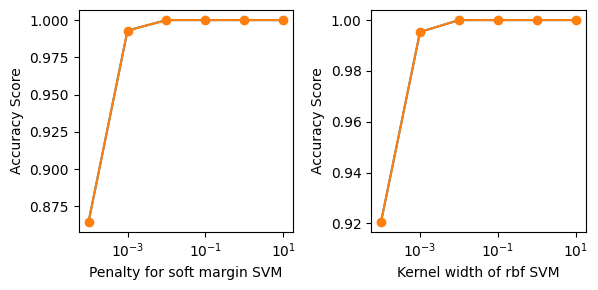

In [1788]:
def svm_hyper_plot(C):
    lst1,lst2 = [],[]
    for c in C[:6]:
        SVM_soft = SVC(C = c, kernel = 'linear', random_state = 361)
        SVM_soft.fit(train_x,train_y)
        pred1 = SVM_soft.predict(train_x)
        acc1 = metrics.accuracy_score(train_y, pred1)
        lst1.append(acc1)
        
        SVM_kernel = SVC(kernel = 'rbf', random_state = 361, gamma = c)
        SVM_kernel.fit(train_x,train_y)
        pred2 = SVM_kernel.predict(train_x)
        acc2 = metrics.accuracy_score(train_y, pred2)
        lst2.append(acc2)
        
    fig = plt.figure(figsize=(6,3))
    plt.subplot(1, 2, 1)
    plt.plot(C[:6], lst1)
    plt.plot(C[:6], lst1, marker = 'o')
    plt.xlabel('Penalty for soft margin SVM')
    plt.ylabel('Accuracy Score')
    plt.xscale('log')
    
    plt.subplot(1, 2, 2)
    plt.plot(C[:6], lst2)
    plt.plot(C[:6], lst2, marker = 'o')
    plt.xlabel('Kernel width of rbf SVM')
    plt.ylabel('Accuracy Score')
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()

svm_hyper_plot(C)

In [1790]:
SVM_soft = SVC(C = .1, kernel = 'linear')
#SVM_kernel = SVC(gamma = .1, kernel = 'rbf')

Apparently, the accuracy score increase when the misclassification penalty and kernel width increase, but notice that it may overfit after value at 0.1 for both terms, then we choose kernel = 'linear' and C = 0.1.

## Neural Network

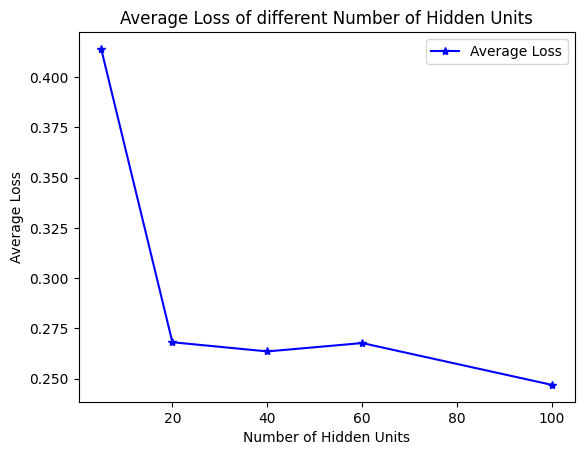

In [1791]:
from sklearn.neural_network import MLPClassifier as DNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import DataConversionWarning
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


# get one hot encode of the training label
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_y.reshape([-1, 1]))
train_onehot_y = ohe.transform(train_y.reshape([-1, 1]))
# different hidden units number
huns = [5, 20, 40, 60, 100]
# the train loss list
losses = []
for hun in huns:
    # build up DNN
    nncla = DNN(
        hidden_layer_sizes=(hun,), 
        activation='logistic', 
        solver='sgd', 
        learning_rate_init=0.01, 
        max_iter=100, 
        random_state=73)
    # train the DNN
    nncla.fit(train_x, train_onehot_y)
    # record average loss
    losses.append(sum(nncla.loss_curve_)/100)
# plot the curve
plt.figure()
plt.plot(huns, losses, 'b*-', label='Average Loss')
plt.title('Average Loss of different Number of Hidden Units')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

It can be seen from the curve trend in the figure that when the number of neurons in the hidden layer of the neural network is between 5 and 20, as the number of neurons in the hidden layer increases, the average loss of the neural network decreases more. This shows that in this interval, increasing the number of neurons is of great help to the convergence of the neural network. In the interval of 20 to 40, as the number of hidden layer neurons increases, the average loss of the neural network does not decrease significantly. This shows that when the number of neurons in the hidden layer is greater than 20, the method of increasing the number of neurons does not help the convergence of the neural network. And more neurons brings a lot of computation. Although the number of neurons is more, the loss is indeed smaller. However, for this dataset, the training cost-effectiveness of increasing the number of neurons after the number of neurons is greater than 20 is relatively low.

In [1792]:
nncla = DNN(hidden_layer_sizes=(40,), activation='logistic', solver='sgd',learning_rate_init=0.01)
nncla

MLPClassifier(activation='logistic', hidden_layer_sizes=(40,),
              learning_rate_init=0.01, solver='sgd')

# Task 3

## 3a

In [1793]:
m = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
training_x_size = m*train_x.shape[0]
training_x_size

array([ 42.8, 128.4, 214. , 299.6, 385.2])

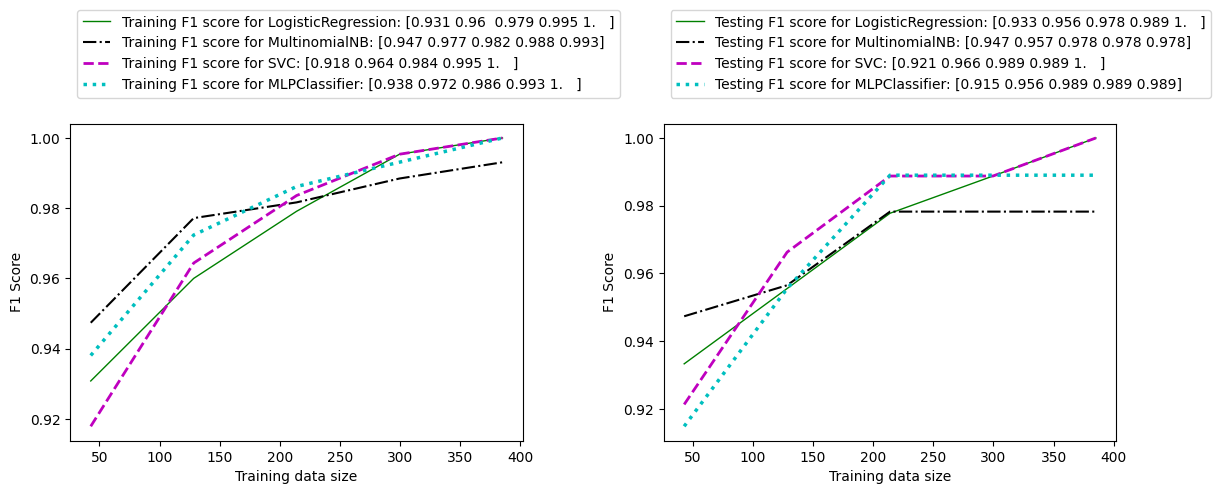

In [1744]:
def train_test_f1_score(m,lst):
    a1,b1,c1 = 1,2,1
    fig = plt.figure(figsize=(12,5))
    color = ['g','k','m','c']
    linetyple = ['-','-.','--',':']
    for num,data in enumerate(lst):
        n = 0
        dic = {LR:[],NB:[],SVM_soft:[],nncla:[]}
        plt.subplot(a1, b1, c1)
        for r in m:
            x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, train_size = r, random_state = 100)
            for i,j in dic.items():
                i.fit(x_train, y_train)
                pred = i.predict(data[0])
                f1_s = metrics.f1_score(data[1],pred)
                j.append(f1_s)
                
        for i,j in dic.items():
            if num == 0:
                plt.plot(training_x_size, j, color = color[n], linestyle = linetyple[n], linewidth = (n+2) / 2,
                         label = f"Training F1 score for {i.__class__.__name__}: {np.round(j,3)}")
                
            else:
                plt.plot(training_x_size, j, color = color[n], linestyle = linetyple[n], linewidth = (n+2) / 2,
                         label = f"Testing F1 score for {i.__class__.__name__}: {np.round(j,3)}")
            plt.xlabel('Training data size')
            plt.ylabel("F1 Score")
            plt.legend(loc='center left', bbox_to_anchor=(0, 1.22))
            n += 1
            
        c1 += 1
        plt.tight_layout()
train_test_f1_score(m,[[train_x,train_y],[test_x,test_y]])

Combining the graphs of the four classifiers, as the number of samples in the training set increases, the F1 score of the training and testing set of the classifier will increase. This phenomenon shows that as the number of samples in the training set increases, the classifier can better fit the data distribution, so there will be higher training set and test set F1 scores.

## 3b

In [1798]:
simplefilter("ignore", category=ConvergenceWarning)
def Hyperparameter_tuning(lst, num = 0):
    tuned_lst = []
    for i,classifier in enumerate(lst):
        if i == 0:
            dic = {'C' : C[1:7]}
        elif i == 1:
            dic = {'alpha' : C[1:7]}     
        elif i == 2:
            dic = {'C' : [0.1,1,10], 'gamma' : [0.1,1,10], 'kernel' : ['rbf','linear']}
        else:
            dic = {'hidden_layer_sizes' : [20, 40, 60, 100], 'learning_rate_init' : [0.01,0.1,1], 
                   'solver' : ['sgd', 'adam'], 'max_iter' : [100, 200], 'activation' : ['logistic']}

        mod = GridSearchCV(classifier, dic, cv = 5, scoring='f1', verbose = 0, n_jobs = -1, return_train_score = True)
            
        mod.fit(train_x, train_y)
        tuned_lst.append(mod.best_estimator_)
        
        if num == 0:
            tr_score = mod.cv_results_['mean_train_score']
            vl_score = mod.cv_results_['mean_test_score']
            classifier_name = classifier.__class__.__name__
            print(f'Training Accuracy for {classifier_name} on 5-Fold Cross Valildation on average is\n {tr_score}\n')
            print(f'Validation Accuracy for {classifier_name} on 5-Fold Cross Valildation on average is\n {vl_score}\n')
            print(f'The Untuned Hyperparameter for {classifier_name} is {classifier.set_params()}\nThe Tuned Hyperparameter for {classifier_name} is {mod.best_params_}\n\n\n')

    if num == 1:
        f1_comparison(tuned_lst, lst)      
        
Hyperparameter_tuning([LR, NB, SVM_soft, nncla])

Training Accuracy for LogisticRegression on 5-Fold Cross Valildation on average is
 [0.97816725 0.99767778 1.         1.         1.         1.        ]

Validation Accuracy for LogisticRegression on 5-Fold Cross Valildation on average is
 [0.94699421 0.96436507 0.96923772 0.96923772 0.96665176 0.96665176]

The Untuned Hyperparameter for LogisticRegression is LogisticRegression(C=0.1)
The Tuned Hyperparameter for LogisticRegression is {'C': 0.1}



Training Accuracy for MultinomialNB on 5-Fold Cross Valildation on average is
 [1.         0.99825749 0.99767778 0.99652505 0.98793593 0.92434001]

Validation Accuracy for MultinomialNB on 5-Fold Cross Valildation on average is
 [0.97930791 0.98615343 0.98599116 0.98128528 0.95407006 0.88789742]

The Untuned Hyperparameter for MultinomialNB is MultinomialNB(alpha=1)
The Tuned Hyperparameter for MultinomialNB is {'alpha': 0.01}



Training Accuracy for SVC on 5-Fold Cross Valildation on average is
 [0.67080706 1.         0.67080706 1.         

We used grivsearchcv to obtain best hyperparameter for each classifier, for each iteration, we also gain its training and validation score, as the result, four classifiers perform well on training and testing phase. 

## 3c

In [1799]:
simplefilter("ignore", category=ConvergenceWarning)
def f1_comparison(tuned_lst, lst):
    for i,classifier in enumerate(tuned_lst):
        classifier.fit(train_x,train_y)
        pred = classifier.predict(test_x)
        score = metrics.f1_score(test_y,pred)
        
        untuned_model = lst[i]
        untuned_model.fit(train_x,train_y)
        pred1 = untuned_model.predict(test_x)
        score1 = metrics.f1_score(test_y,pred1)

        print(f'F1 Score for {classifier.__class__.__name__} before: {score1}\nF1 Score after hyperparameter tuning: {score}\n\n')

Hyperparameter_tuning([LR, NB, SVM_soft, nncla], 1)    

F1 Score for LogisticRegression before: 1.0
F1 Score after hyperparameter tuning: 1.0


F1 Score for MultinomialNB before: 0.989010989010989
F1 Score after hyperparameter tuning: 0.989010989010989


F1 Score for SVC before: 1.0
F1 Score after hyperparameter tuning: 1.0


F1 Score for MLPClassifier before: 0.989010989010989
F1 Score after hyperparameter tuning: 1.0




/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

We basically just compare the f1 score before and after tuning. It is an unexpected outcome that the F1 score are all same(except nn) before and after tuning, we will discuss more detail in report.

ignore warning